In [81]:
%matplotlib inline
import chainer
from chainer import optimizers
import numpy as np
import csv
import matplotlib.pyplot as plt
from net import Net

In [97]:
n_epoch = 100
batchsize = 20
bprop_len = 100
n_units = 200
grad_clip = 5
use_gpu = False

In [93]:
xp = cuda.cupy if use_gpu is True else np

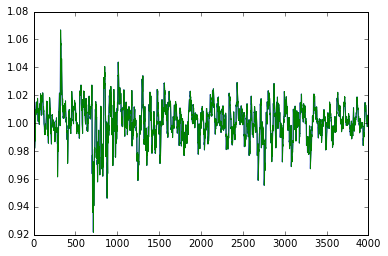

In [94]:
train_data_x = []
train_data_y = []
f = open('30minutes.csv','r')
data = csv.reader(f, delimiter=',')
for row in data:
    train_data_x.append(row[7])
    train_data_y.append(row[7])
train_data_x = np.asarray(train_data_x, dtype=np.float32)
train_data_y = np.asarray(train_data_y, dtype=np.float32)
train_data_x = train_data_x[:-1]
train_data_x = train_data_x[1:]
plt.plot(train_data_x[:4000])
plt.plot(train_data_y[:4000])

In [98]:
#ネットワークを試す関数
def evaluate(model,num,origin=0):
    t = chainer.Variable(xp.array([[origin]],dtype=np.float32))
    output = []
    evaluator = model.copy()
    evaluator.reset_state()
    for i in range(num):
        t = evaluator.predict(t)
        output.append(t.data[0])
    return output

In [99]:
model = Net(1, n_units)#入力の次元数, 中間層の次元数
if use_gpu is True:
    model.to_gpu()
optimizer = optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(grad_clip))
loss = []
length = len(train_data_x)
jump = length // batchsize
batch_idxs = list(range(batchsize))
accum_loss = 0
epoch = 0
loss_data = 0
for i in range(jump * n_epoch):
    #TODO:データの食わせ方間違ってるかも
    x = chainer.Variable(xp.asarray([[train_data_x[(jump * i + j) % length]] for j in batch_idxs]))
    y = chainer.Variable(xp.asarray([[train_data_y[(jump * i + j) % length]] for j in batch_idxs]))
    loss_i = model(x,y)
    accum_loss += loss_i
    loss_data += accum_loss.data
        
    if (i+1) % jump == 0:
        epoch += 1
        if epoch % 10 == 0:
            print('epoch {}, error {}'.format(epoch, loss_data / length))
        loss.append(loss_data / length)
        loss_data = 0
        model.reset_state()
        
    
    if (i+1) % bprop_len == 0:
        model.zerograds()
        accum_loss.backward()
        accum_loss.unchain_backward()
        accum_loss = 0
        optimizer.update()

epoch 10, error 0.0012337102042634025
epoch 20, error 0.0009019626681572138
epoch 30, error 0.003194855793041924
epoch 40, error 0.0005354279333154332
epoch 50, error 0.0004144298457026049
epoch 60, error 0.0002811311192187063
epoch 70, error 0.000735448723043017
epoch 80, error 0.00045882418202992063
epoch 90, error 0.00025694450958273674
epoch 100, error 0.001468795750028409


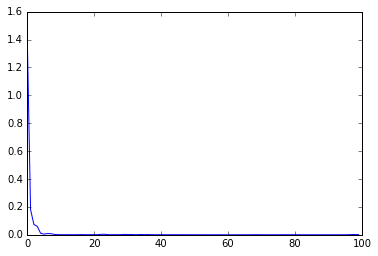

In [102]:
plt.plot(loss[:])

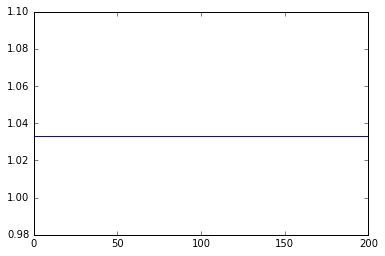

In [103]:
output = evaluate(model,1000,origin=1)
plt.plot(output[400:600])